In [23]:
'''
Chapter 4: Fine-Tuning GPT3 with Custom Examples 
    Overview of Transfer Learning & Fine-tuning
    Overview of GPT3 Fine-tuning API
    Using Fine-tuned GPT3 Models to Get Better Results
'''

'\nChapter 4: Fine-Tuning GPT3 with Custom Examples \n    Overview of Transfer Learning & Fine-tuning\n    Overview of GPT3 Fine-tuning API\n    Using Fine-tuned GPT3 Models to Get Better Results\n'

In [ ]:
import pandas as pd

In [91]:
from datasets import load_dataset
import os
import openai

openai.api_key = os.getenv("OPENAI_API_KEY")

def test_prompt(prompt, suppress=False, model='text-davinci-003', max_tokens=256, **kwargs):

    response = openai.Completion.create(
      model=model,
      prompt=prompt,
      max_tokens=max_tokens,
      **kwargs
    )
    if not suppress:
        print(f'PROMPT:\n------\n{prompt}\n------\nRESPONSE\n------\n{prompt}{response.choices[0].text}')


dataset = load_dataset("gsm8k", "main")

Found cached dataset gsm8k (/Users/sinanozdemir/.cache/huggingface/datasets/gsm8k/main/1.1.0/37bfb08b1d4fcbb01f06b03d9e1ef5f1fcbd4d3af3d08842c50d7305091285ba)


  0%|          | 0/2 [00:00<?, ?it/s]

In [92]:
dataset

DatasetDict({
    train: Dataset({
        features: ['question', 'answer'],
        num_rows: 7473
    })
    test: Dataset({
        features: ['question', 'answer'],
        num_rows: 1319
    })
})

In [93]:
dataset['train'][0]

{'question': 'Natalia sold clips to 48 of her friends in April, and then she sold half as many clips in May. How many clips did Natalia sell altogether in April and May?',
 'answer': 'Natalia sold 48/2 = <<48/2=24>>24 clips in May.\nNatalia sold 48+24 = <<48+24=72>>72 clips altogether in April and May.\n#### 72'}

In [94]:
dataset['train'][0]

{'question': 'Natalia sold clips to 48 of her friends in April, and then she sold half as many clips in May. How many clips did Natalia sell altogether in April and May?',
 'answer': 'Natalia sold 48/2 = <<48/2=24>>24 clips in May.\nNatalia sold 48+24 = <<48+24=72>>72 clips altogether in April and May.\n#### 72'}

# no chain of thought    

In [172]:
training_rows, testing_rows = [], []


for row in list(dataset['train']):
    # don't forget the space before the label. It's not technically required, but GPT is
    # used to predicing a space so it will make the training easier
    training_rows.append({"prompt": row['question'], "completion": row['answer'].split('####')[-1]})

for row in list(dataset['test']):
    # don't forget the space before the label. It's not technically required, but GPT is
    # used to predicing a space so it will make the training easier
    testing_rows.append({"prompt": row['question'], "completion": row['answer'].split('####')[-1]})

    

In [173]:
training_rows[0], testing_rows[0]

({'prompt': 'Natalia sold clips to 48 of her friends in April, and then she sold half as many clips in May. How many clips did Natalia sell altogether in April and May?',
  'completion': ' 72'},
 {'prompt': "Janet’s ducks lay 16 eggs per day. She eats three for breakfast every morning and bakes muffins for her friends every day with four. She sells the remainder at the farmers' market daily for $2 per fresh duck egg. How much in dollars does she make every day at the farmers' market?",
  'completion': ' 18'})

In [175]:
sum([len(training_row['prompt'] + training_row['completion']) for training_row in training_rows]) + \
sum([len(testing_row['prompt'] + testing_row['completion']) for testing_row in testing_rows])


2098011

In [185]:
import json

with open('../data/openai-train.jsonl', 'w') as outfile:
    for entry in training_rows:
        json.dump(entry, outfile)
        outfile.write('\n')
        

with open('../data/openai-validation.jsonl', 'w') as outfile:
    for entry in testing_rows:
        json.dump(entry, outfile)
        outfile.write('\n')

In [186]:
!openai api fine_tunes.create --training_file "../data/openai-train.jsonl" --validation_file "../data/openai-validation.jsonl" --model "ada" --n_epochs 10


Upload progress: 100%|█████████████████████| 2.03M/2.03M [00:00<00:00, 999Mit/s]
Uploaded file from ../data/openai-train.jsonl: file-WSJf20MedIx7QcODGByVrl6M
Upload progress: 100%|███████████████████████| 365k/365k [00:00<00:00, 163Mit/s]
Uploaded file from ../data/openai-validation.jsonl: file-CH2xTvOjCHH561yWW9c0Tqqo
Created fine-tune: ft-JuCUmhbl4Had6UPVudmyRzIA
Streaming events until fine-tuning is complete...

(Ctrl-C will interrupt the stream, but not cancel the fine-tune)
[2023-03-17 20:43:33] Created fine-tune: ft-JuCUmhbl4Had6UPVudmyRzIA

Stream interrupted (client disconnected).
To resume the stream, run:

  openai api fine_tunes.follow -i ft-JuCUmhbl4Had6UPVudmyRzIA



In [191]:
!openai api fine_tunes.follow -i ft-JuCUmhbl4Had6UPVudmyRzIA

[2023-03-17 20:43:33] Created fine-tune: ft-JuCUmhbl4Had6UPVudmyRzIA
[2023-03-17 20:45:58] Fine-tune costs $1.68
[2023-03-17 20:45:58] Fine-tune enqueued. Queue number: 0
[2023-03-17 20:45:59] Fine-tune started
[2023-03-17 20:52:12] Completed epoch 1/10
[2023-03-17 20:58:08] Completed epoch 2/10
[2023-03-17 21:04:03] Completed epoch 3/10
[2023-03-17 21:10:00] Completed epoch 4/10
[2023-03-17 21:15:56] Completed epoch 5/10
[2023-03-17 21:21:52] Completed epoch 6/10
[2023-03-17 21:27:48] Completed epoch 7/10
[2023-03-17 21:33:45] Completed epoch 8/10
[2023-03-17 21:39:42] Completed epoch 9/10
[2023-03-17 21:45:40] Completed epoch 10/10
[2023-03-17 21:46:05] Uploaded model: ada:ft-personal-2023-03-18-04-46-04
[2023-03-17 21:46:07] Uploaded result file: file-LYOuUNZhCqjVV17paSv85Sz3
[2023-03-17 21:46:07] Fine-tune succeeded

Job complete! Status: succeeded 🎉
Try out your fine-tuned model:

openai api completions.create -m ada:ft-personal-2023-03-18-04-46-04 -p <YOUR_PROMPT>


In [190]:
!openai wandb sync -i ft-JuCUmhbl4Had6UPVudmyRzIA


wandb: Currently logged in as: profoz. Use `wandb login --relogin` to force relogin
wandb: Tracking run with wandb version 0.14.0
wandb: Run data is saved locally in /Users/sinanozdemir/Teaching/Pearson/quick-start-llms/notebooks/wandb/run-20230318_065318-ft-JuCUmhbl4Had6UPVudmyRzIA
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run ft-JuCUmhbl4Had6UPVudmyRzIA
wandb: ⭐️ View project at https://wandb.ai/profoz/GPT-3
wandb: 🚀 View run at https://wandb.ai/profoz/GPT-3/runs/ft-JuCUmhbl4Had6UPVudmyRzIA
^C

wandb: Waiting for W&B process to finish... (success).


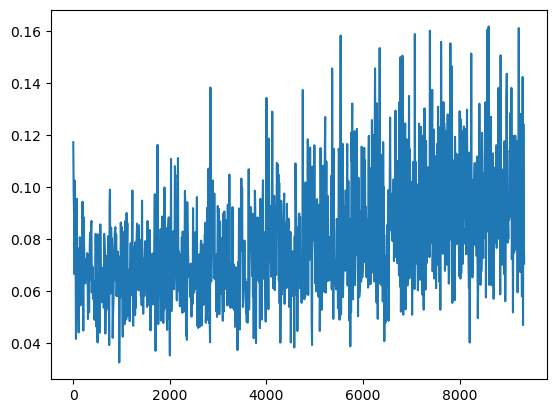

In [326]:
!openai api fine_tunes.results -i ft-JuCUmhbl4Had6UPVudmyRzIA > result.csv

pd.read_csv('result.csv')['validation_loss'].dropna().plot()

In [564]:
# Cancel a job
# !openai api fine_tunes.cancel -i ft-G7L1MvxpGJiB8l0ZkxjiMDJU

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
[organization=user-9vr5p5naslsmcksivdeejxum] Error: Cannot cancel a job ft-G7L1MvxpGJiB8l0ZkxjiMDJU that already has status "cancelled". (HTTP status code: 400)


In [192]:
FINE_TUNED_MODEL = 'ada:ft-personal-2023-03-18-04-46-04'

In [193]:
testing_rows[0]

{'prompt': "Janet’s ducks lay 16 eggs per day. She eats three for breakfast every morning and bakes muffins for her friends every day with four. She sells the remainder at the farmers' market daily for $2 per fresh duck egg. How much in dollars does she make every day at the farmers' market?",
 'completion': ' 18'}

In [194]:
test_prompt(
    testing_rows[0]['prompt'],
    model=FINE_TUNED_MODEL,
    max_tokens=512,
)

PROMPT:
------
Janet’s ducks lay 16 eggs per day. She eats three for breakfast every morning and bakes muffins for her friends every day with four. She sells the remainder at the farmers' market daily for $2 per fresh duck egg. How much in dollars does she make every day at the farmers' market?
------
RESPONSE
------
Janet’s ducks lay 16 eggs per day. She eats three for breakfast every morning and bakes muffins for her friends every day with four. She sells the remainder at the farmers' market daily for $2 per fresh duck egg. How much in dollars does she make every day at the farmers' market? 96,800,000,000,000,000,000,000,000,000,000,000,000,000,000,000,000,000,000,000,000,000,000,000,000,000,000,000,000,000,000,000,000,000,000,000,000,000,000,000,000,000,000,000,000,000,000,000,000,000,000,000,000,000,000,000,000,000,000,000,000,000,000,000,0000,0000,0000,0000,0000,0000,0000,0000 ................................                                        >                                

In [623]:
import re
def test_testing_row(testing_row, model, verbose=False, sep='####', **openai_kwargs):
    if verbose:
        print('ROW\n-----------')
        print(testing_row)
        print()
    
    true = float(testing_row['completion'].split(sep)[1].strip().lower().replace(',', ''))

    pred = openai.Completion.create(
          model=model,
          prompt=testing_row['prompt'],
          max_tokens=256,
        **openai_kwargs
        ).choices[0].text
    
    if verbose:
        print('OPENAI RESPONSE\n-----------')
        print(pred)
        print()
        print(pred.split(sep)[1])
        print()
            

    pattern = re.compile(sep + r'\s*([\d,]+)')
    match = pattern.search(pred)

    if match:
        result = match.group(1)
        result = result.replace(',', '') # Remove commas if any
        pred = float(result)
    else:
        pred = 0

    return true, pred, true == pred

In [624]:
import numpy as np
from tqdm import tqdm

def evaluate_performance(model, testing_rows, sep, **openai_kwargs):
    data = []
    for row in tqdm(testing_rows):
        data.append(test_testing_row(row, model, verbose=False, sep=sep, **openai_kwargs))
    booleans = [_[-1] for _ in data]
    accuracy = sum(booleans)/len(booleans)


    actual = [item[0] for item in data]
    predicted = [item[1] for item in data]

    # Calculate the differences and squared differences
    differences = [abs(a - p) for a, p in zip(actual, predicted)]
    squared_differences = [(a - p)**2 for a, p in zip(actual, predicted)]

    # Calculate the MAE
    mae = np.mean(differences)

    # Calculate the RMSE
    rmse = np.sqrt(np.mean(squared_differences))

    return dict(accuracy=accuracy, mae=mae, rmse=rmse)
        

In [610]:
results = evaluate_performance('ada:ft-personal-2023-03-18-04-46-04', testing_rows, ' ', temperature=0)

for key, value in results.items():
    print(f'{key}: {value:.2f}')

accuracy: 0.07
mae: 57333.86
rmse: 1658915.02


# Chain of Thought Reasoning

In [209]:
main_training_rows, main_testing_rows = [], []

for row in list(dataset['train']):
    # don't forget the space before the label. It's not technically required, but GPT is
    # used to predicing a space so it will make the training easier
    main_training_rows.append({"prompt": row['question'], "completion": ' ' + row['answer']})

for row in list(dataset['test']):
    # don't forget the space before the label. It's not technically required, but GPT is
    # used to predicing a space so it will make the training easier
    main_testing_rows.append({"prompt": row['question'], "completion": ' ' + row['answer']})


with open('../data/openai-train-cot.jsonl', 'w') as outfile:
    for entry in main_training_rows:
        json.dump(entry, outfile)
        outfile.write('\n')
        

with open('../data/openai-validation-cot.jsonl', 'w') as outfile:
    for entry in main_testing_rows:
        json.dump(entry, outfile)
        outfile.write('\n')

In [256]:
main_testing_rows[2]

{'prompt': 'Josh decides to try flipping a house.  He buys a house for $80,000 and then puts in $50,000 in repairs.  This increased the value of the house by 150%.  How much profit did he make?',
 'completion': ' The cost of the house and repairs came out to 80,000+50,000=$<<80000+50000=130000>>130,000\nHe increased the value of the house by 80,000*1.5=<<80000*1.5=120000>>120,000\nSo the new value of the house is 120,000+80,000=$<<120000+80000=200000>>200,000\nSo he made a profit of 200,000-130,000=$<<200000-130000=70000>>70,000\n#### 70000'}

In [210]:
main_training_rows[0], main_testing_rows[0]

({'prompt': 'Natalia sold clips to 48 of her friends in April, and then she sold half as many clips in May. How many clips did Natalia sell altogether in April and May?',
  'completion': ' Natalia sold 48/2 = <<48/2=24>>24 clips in May.\nNatalia sold 48+24 = <<48+24=72>>72 clips altogether in April and May.\n#### 72'},
 {'prompt': "Janet’s ducks lay 16 eggs per day. She eats three for breakfast every morning and bakes muffins for her friends every day with four. She sells the remainder at the farmers' market daily for $2 per fresh duck egg. How much in dollars does she make every day at the farmers' market?",
  'completion': ' Janet sells 16 - 3 - 4 = <<16-3-4=9>>9 duck eggs a day.\nShe makes 9 * 2 = $<<9*2=18>>18 every day at the farmer’s market.\n#### 18'})

In [211]:
sum([len(main_training_row['prompt'] + main_training_row['completion']) for main_training_row in main_training_rows]) + \
sum([len(main_testing_row['prompt'] + main_testing_row['completion']) for main_testing_row in main_testing_rows])


4612419

In [220]:
!openai api fine_tunes.create --training_file "../data/openai-train-cot.jsonl" --validation_file "../data/openai-validation-cot.jsonl" --model "ada" --n_epochs 10


Created fine-tune: ft-uJlrLMWlvOMmj1v5mJ1Y0P9Q
Streaming events until fine-tuning is complete...

(Ctrl-C will interrupt the stream, but not cancel the fine-tune)
[2023-03-19 15:30:59] Created fine-tune: ft-uJlrLMWlvOMmj1v5mJ1Y0P9Q

Stream interrupted (client disconnected).
To resume the stream, run:

  openai api fine_tunes.follow -i ft-uJlrLMWlvOMmj1v5mJ1Y0P9Q



In [ ]:
# Note the cost is over twice as much because we have more than twice as many characters

In [ ]:
# $4.50 for ada would be $337.16 on davinci for reference

In [230]:
!openai api fine_tunes.follow -i ft-uJlrLMWlvOMmj1v5mJ1Y0P9Q

[2023-03-19 15:30:59] Created fine-tune: ft-uJlrLMWlvOMmj1v5mJ1Y0P9Q
[2023-03-19 15:37:54] Fine-tune costs $4.50
[2023-03-19 15:37:55] Fine-tune enqueued. Queue number: 0
[2023-03-19 15:37:55] Fine-tune started
[2023-03-19 15:44:06] Completed epoch 1/10
[2023-03-19 15:55:36] Completed epoch 3/10
[2023-03-19 16:01:21] Completed epoch 4/10
[2023-03-19 16:07:06] Completed epoch 5/10
[2023-03-19 16:12:52] Completed epoch 6/10
[2023-03-19 16:18:37] Completed epoch 7/10
[2023-03-19 16:24:29] Completed epoch 8/10
[2023-03-19 16:30:21] Completed epoch 9/10
[2023-03-19 16:36:14] Completed epoch 10/10
[2023-03-19 16:36:36] Uploaded model: ada:ft-personal-2023-03-19-23-36-36
[2023-03-19 16:36:37] Uploaded result file: file-x37bSOqbcJhxZU37gw3RZoEZ
[2023-03-19 16:36:37] Fine-tune succeeded

Job complete! Status: succeeded 🎉
Try out your fine-tuned model:

openai api completions.create -m ada:ft-personal-2023-03-19-23-36-36 -p <YOUR_PROMPT>


In [231]:
!openai wandb sync -i ft-uJlrLMWlvOMmj1v5mJ1Y0P9Q


wandb: Currently logged in as: profoz. Use `wandb login --relogin` to force relogin
wandb: Tracking run with wandb version 0.14.0
wandb: Run data is saved locally in /Users/sinanozdemir/Teaching/Pearson/quick-start-llms/notebooks/wandb/run-20230319_164853-ft-uJlrLMWlvOMmj1v5mJ1Y0P9Q
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run ft-uJlrLMWlvOMmj1v5mJ1Y0P9Q
wandb: ⭐️ View project at https://wandb.ai/profoz/GPT-3
wandb: 🚀 View run at https://wandb.ai/profoz/GPT-3/runs/ft-uJlrLMWlvOMmj1v5mJ1Y0P9Q
wandb: Waiting for W&B process to finish... (success).
wandb: 
wandb: Run history:
wandb:             elapsed_examples ▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
wandb:               elapsed_tokens ▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
wandb:                training_loss ▇▅▅▇▄▇▇█▄▅▅▄▃▃▄▃▃▄▃▃▃▃▂▃▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁
wandb:   training_sequence_accuracy ▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃▂▁▅▄▁▃▂▅▆▆█
wandb:      training_token_accuracy ▁▂▃▃▅▂▃▂▅▃▄▅▅▅▅▄▆▄▅▅▆▆▆▆▇▇▇▆▇█▇▇████████
wandb:       

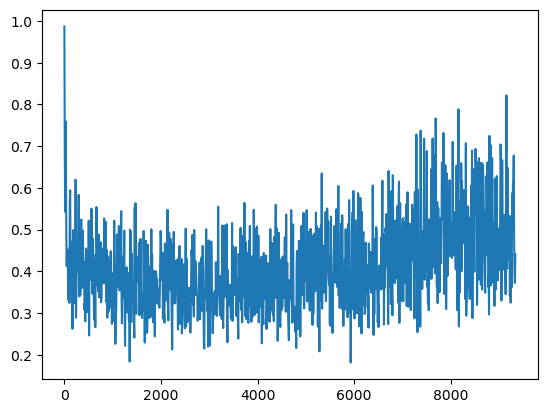

In [325]:
!openai api fine_tunes.results -i ft-uJlrLMWlvOMmj1v5mJ1Y0P9Q > cot_result.csv

pd.read_csv('cot_result.csv')['validation_loss'].dropna().plot()

In [254]:
testing_rows[0]

{'prompt': "Janet’s ducks lay 16 eggs per day. She eats three for breakfast every morning and bakes muffins for her friends every day with four. She sells the remainder at the farmers' market daily for $2 per fresh duck egg. How much in dollars does she make every day at the farmers' market?",
 'completion': ' 18'}

In [672]:
results = evaluate_performance('ada:ft-personal-2023-03-19-23-36-36', main_testing_rows, '####', temperature=0)

for key, value in results.items():
    print(f'{key}: {value:.2f}')

accuracy: 0.06974981046247157
mae: 4.3651067153720676e+275
rmse: inf


# Socratic Chain of Thought

In [234]:
socratic_dataset = load_dataset("gsm8k", "socratic")

socratic_training_rows, socratic_testing_rows = [], []

for row in list(socratic_dataset['train']):
    # don't forget the space before the label. It's not technically required, but GPT is
    # used to predicing a space so it will make the training easier
    socratic_training_rows.append({"prompt": row['question'], "completion": ' ' + row['answer']})

for row in list(socratic_dataset['test']):
    # don't forget the space before the label. It's not technically required, but GPT is
    # used to predicing a space so it will make the training easier
    socratic_testing_rows.append({"prompt": row['question'], "completion": ' ' + row['answer']})


with open('../data/openai-train-cot-socratic.jsonl', 'w') as outfile:
    for entry in socratic_training_rows:
        json.dump(entry, outfile)
        outfile.write('\n')
        

with open('../data/openai-validation-cot-socratic.jsonl', 'w') as outfile:
    for entry in socratic_testing_rows:
        json.dump(entry, outfile)
        outfile.write('\n')

Found cached dataset gsm8k (/Users/sinanozdemir/.cache/huggingface/datasets/gsm8k/socratic/1.1.0/37bfb08b1d4fcbb01f06b03d9e1ef5f1fcbd4d3af3d08842c50d7305091285ba)


  0%|          | 0/2 [00:00<?, ?it/s]

In [235]:
sum([len(socratic_training_rows['prompt'] + socratic_training_rows['completion']) for socratic_training_rows in socratic_training_rows]) + \
sum([len(socratic_testing_row['prompt'] + socratic_testing_row['completion']) for socratic_testing_row in socratic_testing_rows])


6069987

In [236]:
# I'd expect 6069987 / 4612419 * $4.50 ~ $5.92 for this training (How's that for some chain of thought prompting?)
# Don't forget it's charged by the token, but I assume a linear relationship so the ratio should still be roughly OK

In [237]:
!openai api fine_tunes.create --training_file "../data/openai-train-cot-socratic.jsonl" --validation_file "../data/openai-validation-cot-socratic.jsonl" --model "ada" --n_epochs 10


Upload progress: 100%|████████████████████| 5.42M/5.42M [00:00<00:00, 2.19Git/s]
Uploaded file from ../data/openai-train-cot-socratic.jsonl: file-1I9DKcUGr0hrYjRQzoDowjiM
Upload progress: 100%|███████████████████████| 977k/977k [00:00<00:00, 386Mit/s]
Uploaded file from ../data/openai-validation-cot-socratic.jsonl: file-UzwI4ClJmSJk3ssyDkUlIt5S
Created fine-tune: ft-g6t3MmlcCDKh3CxMPOnTi3gj
Streaming events until fine-tuning is complete...

(Ctrl-C will interrupt the stream, but not cancel the fine-tune)
[2023-03-19 16:49:32] Created fine-tune: ft-g6t3MmlcCDKh3CxMPOnTi3gj

Stream interrupted (client disconnected).
To resume the stream, run:

  openai api fine_tunes.follow -i ft-g6t3MmlcCDKh3CxMPOnTi3gj



In [246]:
!openai api fine_tunes.follow -i ft-g6t3MmlcCDKh3CxMPOnTi3gj

[2023-03-19 16:49:32] Created fine-tune: ft-g6t3MmlcCDKh3CxMPOnTi3gj
[2023-03-19 16:55:14] Fine-tune costs $5.64
[2023-03-19 16:55:15] Fine-tune enqueued. Queue number: 0
[2023-03-19 16:55:18] Fine-tune started
[2023-03-19 17:01:29] Completed epoch 1/10
[2023-03-19 17:07:18] Completed epoch 2/10
[2023-03-19 17:13:08] Completed epoch 3/10
[2023-03-19 17:18:59] Completed epoch 4/10
[2023-03-19 17:24:49] Completed epoch 5/10
[2023-03-19 17:30:38] Completed epoch 6/10
[2023-03-19 17:36:29] Completed epoch 7/10
[2023-03-19 17:42:19] Completed epoch 8/10
[2023-03-19 17:48:08] Completed epoch 9/10
[2023-03-19 17:53:57] Completed epoch 10/10
[2023-03-19 17:54:19] Uploaded model: ada:ft-personal-2023-03-20-00-54-19
[2023-03-19 17:54:21] Uploaded result file: file-UG483FmariRlrogoYoAAgvhW
[2023-03-19 17:54:21] Fine-tune succeeded

Job complete! Status: succeeded 🎉
Try out your fine-tuned model:

openai api completions.create -m ada:ft-personal-2023-03-20-00-54-19 -p <YOUR_PROMPT>


In [247]:
!openai wandb sync -i ft-g6t3MmlcCDKh3CxMPOnTi3gj


wandb: Currently logged in as: profoz. Use `wandb login --relogin` to force relogin
wandb: Tracking run with wandb version 0.14.0
wandb: Run data is saved locally in /Users/sinanozdemir/Teaching/Pearson/quick-start-llms/notebooks/wandb/run-20230319_175536-ft-g6t3MmlcCDKh3CxMPOnTi3gj
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run ft-g6t3MmlcCDKh3CxMPOnTi3gj
wandb: ⭐️ View project at https://wandb.ai/profoz/GPT-3
wandb: 🚀 View run at https://wandb.ai/profoz/GPT-3/runs/ft-g6t3MmlcCDKh3CxMPOnTi3gj
wandb: Waiting for W&B process to finish... (success).
wandb: | 12.019 MB of 12.019 MB uploaded (0.000 MB deduped)
wandb: Run history:
wandb:             elapsed_examples ▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
wandb:               elapsed_tokens ▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
wandb:                training_loss ▆█▅▇▆▆▇▄▅▄▄▇▄▄▅▅▄▄▅▅▄▃▃▃▂▂▂▃▂▂▁▂▁▁▁▁▁▁▁▁
wandb:   training_sequence_accuracy ▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▁▂▅▂▄▅▇▄▇▇▄█
wandb:      training_token_accuracy ▁▁

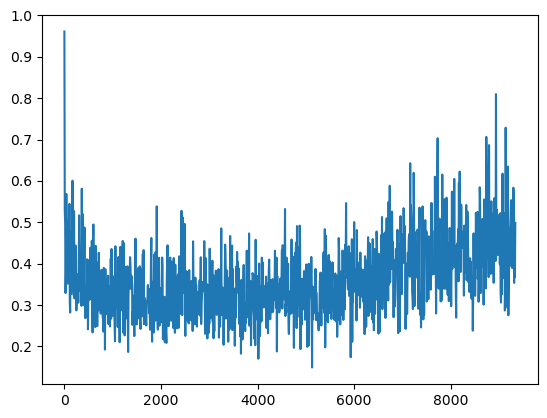

In [327]:
!openai api fine_tunes.results -i ft-g6t3MmlcCDKh3CxMPOnTi3gj > cot_soc_result.csv

pd.read_csv('cot_soc_result.csv')['validation_loss'].dropna().plot()

In [313]:
socratic_testing_rows[12]

{'prompt': 'Carlos is planting a lemon tree. The tree will cost $90 to plant. Each year it will grow 7 lemons, which he can sell for $1.5 each. It costs $3 a year to water and feed the tree. How many years will it take before he starts earning money on the lemon tree?',
 'completion': ' How many lemons does Carlos sell each year? ** He makes $10.5 selling lemons each year because 7 x 1.5 = <<7*1.5=10.5>>10.5\nHow much money does Carlos earn from the lemon tree each year? ** He earns $7.5 each year from the lemon tree because 10.5 - 3 = <<10.5-3=7.5>>7.5\nHow many years will it take before he starts earning money on the lemon tree? ** It will take 12 years to earn enough to pay off the tree because 90 / 7.5 = <<90/7.5=12>>12\nHow many years will it take before he starts earning money on the lemon tree? ** He will make money in year 13 because 12 + 1 = <<12+1=13>>13\n#### 13'}

In [310]:
# TODO try a pre-training on documentation of the socratic method and then the socratic data??

In [630]:
results = evaluate_performance('ada:ft-personal-2023-03-20-00-54-19', socratic_testing_rows, '####', temperature=0)

for key, value in results.items():
    print(f'{key}: {value:.2f}')

100%|██████████████████████████████████████████████████████████████████████| 1319/1319 [43:04<00:00,  1.96s/it]

accuracy: 0.08
mae: 21703.73
rmse: 354397.15


In [328]:
# ● Instruct GPT-3 (ada 350M, babbage 1.3B, curie 6.7B, and davinci 175B) (Ouyang et al., 2022)
# https://paperswithcode.com/sota/arithmetic-reasoning-on-gsm8k
# https://www.cs.princeton.edu/courses/archive/fall22/cos597G/lectures/lec09.pdf

In [ ]:
# train socratic on 4 epochs

In [332]:
!openai api fine_tunes.create --training_file "file-1I9DKcUGr0hrYjRQzoDowjiM" --validation_file "file-UzwI4ClJmSJk3ssyDkUlIt5S" --model "ada" --n_epochs 4


Created fine-tune: ft-ylTGR76hLtJM2F4mVuFThlEA
Streaming events until fine-tuning is complete...

(Ctrl-C will interrupt the stream, but not cancel the fine-tune)
[2023-03-21 21:09:03] Created fine-tune: ft-ylTGR76hLtJM2F4mVuFThlEA
^C


In [343]:
!openai api fine_tunes.follow -i ft-ylTGR76hLtJM2F4mVuFThlEA

[2023-03-21 21:09:03] Created fine-tune: ft-ylTGR76hLtJM2F4mVuFThlEA
[2023-03-21 21:12:26] Fine-tune costs $2.26
[2023-03-21 21:12:27] Fine-tune enqueued
[2023-03-21 23:19:15] Fine-tune is in the queue. Queue number: 31
[2023-03-21 23:19:16] Fine-tune is in the queue. Queue number: 30
[2023-03-21 23:20:00] Fine-tune is in the queue. Queue number: 29
[2023-03-21 23:20:43] Fine-tune is in the queue. Queue number: 28
[2023-03-21 23:20:43] Fine-tune is in the queue. Queue number: 27
[2023-03-21 23:21:17] Fine-tune is in the queue. Queue number: 26
[2023-03-21 23:26:54] Fine-tune is in the queue. Queue number: 25
[2023-03-21 23:27:54] Fine-tune is in the queue. Queue number: 24
[2023-03-21 23:30:20] Fine-tune is in the queue. Queue number: 23
[2023-03-21 23:31:00] Fine-tune is in the queue. Queue number: 22
[2023-03-21 23:34:25] Fine-tune is in the queue. Queue number: 21
[2023-03-21 23:42:54] Fine-tune is in the queue. Queue number: 20
[2023-03-21 23:43:17] Fine-tune is in the queue. Queue

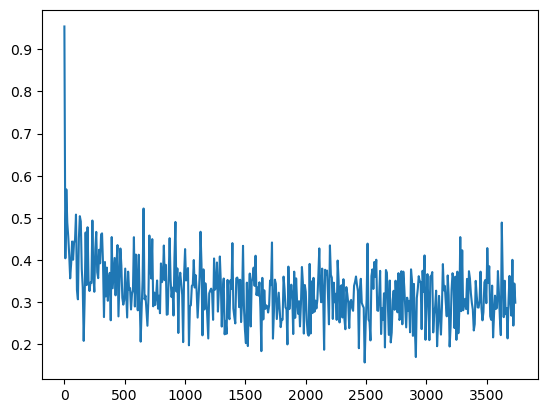

In [344]:
!openai api fine_tunes.results -i ft-ylTGR76hLtJM2F4mVuFThlEA > cot_soc_result.csv

pd.read_csv('cot_soc_result.csv')['validation_loss'].dropna().plot()

In [337]:
# !openai api fine_tunes.cancel -i ft-KoOEtt6ds473Lu94Pb41LOBj

[organization=user-9vr5p5naslsmcksivdeejxum] Error: Cannot cancel a job ft-KoOEtt6ds473Lu94Pb41LOBj that already has status "cancelled". (HTTP status code: 400)


In [493]:
test_testing_row(
    socratic_testing_rows[31], 'ada:ft-personal-2023-03-22-08-36-02', verbose=True,
    best_of=1, temperature=0
)


ROW
-----------
{'prompt': 'Gunter is trying to count the jelly beans in a jar. He asks his friends how many they think are in the jar. One says 80. Another says 20 more than half the first one. A third says 25% more than the first one. What is their average guess?', 'completion': ' How many jelly beans does the second person guess? ** The second person guessed 60 because 20 + (80/2)= <<20+(80/2)=60>>60\nHow many jelly beans does the second person guess? ** The second guessed 100 because 80 x 1.25 = <<80*1.25=100>>100\nHow many jelly beans are in total? ** The total amount guessed is 240 because 80 + 60 + 100 = <<80+60+100=240>>240\nWhat is the average amount guessed? ** The average amount guessed is 80 because 240 / 3 = <<240/3=80>>80\n#### 80'}

OPENAI RESPONSE
-----------
 How many jelly beans are there? ** Half the first jar has 80 jelly beans.
How many jelly beans are there? ** The first jar has 80/2 = <<80/2=40>>40 jelly beans.
How many jelly beans are there? ** The second jar ha

(80.0, 5.0, False)

In [631]:
results = evaluate_performance('ada:ft-personal-2023-03-22-08-36-02', socratic_testing_rows, '####', temperature=0)

for key, value in results.items():
    print(f'{key}: {value:.2f}')

100%|██████████████████████████████████████████████████████████████████████| 1319/1319 [43:35<00:00,  1.98s/it]

accuracy: 0.09
mae: 30425.33
rmse: 711837.57


In [376]:
socratic_dataset['train'][0]

{'question': 'Natalia sold clips to 48 of her friends in April, and then she sold half as many clips in May. How many clips did Natalia sell altogether in April and May?',
 'answer': 'How many clips did Natalia sell in May? ** Natalia sold 48/2 = <<48/2=24>>24 clips in May.\nHow many clips did Natalia sell altogether in April and May? ** Natalia sold 48+24 = <<48+24=72>>72 clips altogether in April and May.\n#### 72'}

In [418]:
custom_socratic_training_rows, custom_socratic_testing_rows = [], []

for row in list(socratic_dataset['train']):
    # don't forget the space before the label. It's not technically required, but GPT is
    # used to predicing a space so it will make the training easier
    custom_socratic_training_rows.append({"prompt": 'Query: ' + row['question'] + '\n\nReasoning:', "completion": ' ' + row['answer'].replace('####', '\nMy final answer is:')})

for row in list(socratic_dataset['test']):
    # don't forget the space before the label. It's not technically required, but GPT is
    # used to predicing a space so it will make the training easier
    custom_socratic_testing_rows.append({"prompt": 'Query: ' + row['question'] + '\n\nReasoning:', "completion": ' ' + row['answer'].replace('####', '\nMy final answer is:')})


with open('../data/openai-train-cot-custom-socratic.jsonl', 'w') as outfile:
    for entry in custom_socratic_training_rows:
        json.dump(entry, outfile)
        outfile.write('\n')
        

with open('../data/openai-validation-cot-custom-socratic.jsonl', 'w') as outfile:
    for entry in custom_socratic_testing_rows:
        json.dump(entry, outfile)
        outfile.write('\n')

In [414]:
custom_socratic_testing_rows[0]

{'prompt': "Query: Janet’s ducks lay 16 eggs per day. She eats three for breakfast every morning and bakes muffins for her friends every day with four. She sells the remainder at the farmers' market daily for $2 per fresh duck egg. How much in dollars does she make every day at the farmers' market?\n\nReasoning:",
 'completion': " How many eggs does Janet sell? ** Janet sells 16 - 3 - 4 = <<16-3-4=9>>9 duck eggs a day.\nHow much does Janet make at the farmers' market? ** She makes 9 * 2 = $<<9*2=18>>18 every day at the farmer’s market.\n\nMy final answer is: 18"}

In [422]:
!openai api fine_tunes.create --training_file "../data/openai-train-cot-custom-socratic.jsonl" --validation_file "../data/openai-validation-cot-custom-socratic.jsonl" --model "ada" --n_epochs 3


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Found potentially duplicated files with name 'openai-train-cot-custom-socratic.jsonl', purpose 'fine-tune' and size 5708132 bytes
file-gqlqNKZEgaEnP3J6iFYuzhSK
Enter file ID to reuse an already uploaded file, or an empty string to upload this file anyway: ^C



In [423]:
!openai api fine_tunes.follow -i ft-eNHJqC7Il1c4Y2O1gfUr2Ern

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
[2023-03-24 13:04:46] Created fine-tune: ft-eNHJqC7Il1c4Y2O1gfUr2Ern
[2023-03-24 13:07:28] Fine-tune costs $1.80
[2023-03-24 13:07:29] Fine-tune enqueued. Queue number: 0
[2023-03-24 13:08:00] Fine-tune started
[2023-03-24 13:14:06] Completed epoch 1/3
[2023-03-24 13:19:51] Completed epoch 2/3
[2023-03-24 13:29:49] Fine-tune started
[2023-03-24 13:36:00] Completed epoch 1/3
[2023-03-24 13:41:49] Completed epoch 2/3
[2023-03-24 13:47:36] Completed epoch 3/3
[2023-03-24 13:48:00] Uploaded model: ada:ft-personal-2023-03-24-20-48-00
[2023-03-24 13:48:01] Uploaded result file: file-L9YIhOeA1clULyVeUWa9HLal
[2023-03-24 13:48:01] Fine-tune succeeded

Job complete! Status: su

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


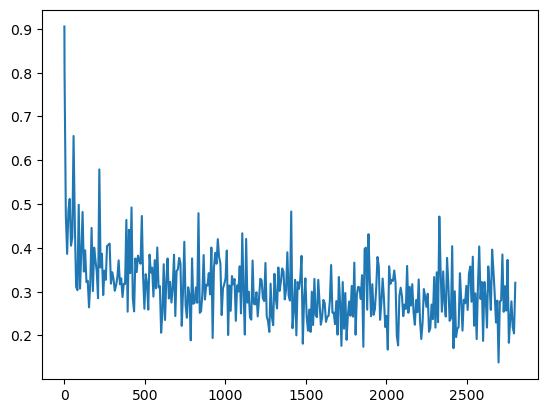

In [424]:
!openai api fine_tunes.results -i ft-eNHJqC7Il1c4Y2O1gfUr2Ern > cot_soc_result_custom.csv

pd.read_csv('cot_soc_result_custom.csv')['validation_loss'].dropna().plot()

In [412]:
custom_socratic_training_rows[0]

{'prompt': 'Query: Natalia sold clips to 48 of her friends in April, and then she sold half as many clips in May. How many clips did Natalia sell altogether in April and May?\n\nReasoning:',
 'completion': ' How many clips did Natalia sell in May? ** Natalia sold 48/2 = <<48/2=24>>24 clips in May.\nHow many clips did Natalia sell altogether in April and May? ** Natalia sold 48+24 = <<48+24=72>>72 clips altogether in April and May.\n\nMy final answer is: 72'}

In [632]:
results = evaluate_performance(
    'ada:ft-personal-2023-03-24-20-48-00', custom_socratic_testing_rows, 'My final answer is:', temperature=0
)

for key, value in results.items():
    print(f'{key}: {value:.2f}')

100%|██████████████████████████████████████████████████████████████████████| 1319/1319 [46:04<00:00,  2.10s/it]

accuracy: 0.07
mae: 56150.74
rmse: 1658145.05


In [585]:
!openai api fine_tunes.create --training_file "file-1I9DKcUGr0hrYjRQzoDowjiM" --validation_file "file-UzwI4ClJmSJk3ssyDkUlIt5S" --model "curie" --n_epochs 3


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Created fine-tune: ft-Ms483CO61JALOuyoJ1MF5cWI
Streaming events until fine-tuning is complete...

(Ctrl-C will interrupt the stream, but not cancel the fine-tune)
[2023-03-26 07:46:23] Created fine-tune: ft-Ms483CO61JALOuyoJ1MF5cWI
[2023-03-26 07:47:22] Fine-tune costs $12.69
[2023-03-26 07:47:22] Fine-tune enqueued. Queue number: 0

Stream interrupted (client disconnected).
To resume the stream, run:

  openai api fine_tunes.follow -i ft-Ms483CO61JALOuyoJ1MF5cWI



In [ ]:
# $2.26 in ada became $12.69 in curie

In [598]:
!openai api fine_tunes.follow -i ft-Ms483CO61JALOuyoJ1MF5cWI

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
[2023-03-26 07:46:23] Created fine-tune: ft-Ms483CO61JALOuyoJ1MF5cWI
[2023-03-26 07:47:22] Fine-tune costs $12.69
[2023-03-26 07:47:22] Fine-tune enqueued. Queue number: 0
[2023-03-26 07:47:25] Fine-tune started
[2023-03-26 07:55:25] Completed epoch 1/3
[2023-03-26 08:02:16] Completed epoch 2/3
[2023-03-26 08:09:08] Completed epoch 3/3
[2023-03-26 08:09:28] Uploaded model: curie:ft-personal-2023-03-26-15-09-27
[2023-03-26 08:09:28] Uploaded result file: file-Ke696bsz6xjgxDv8M9HFDkSv
[2023-03-26 08:09:28] Fine-tune succeeded

Job complete! Status: succeeded 🎉
Try out your fine-tuned model:

openai api completions.create -m curie:ft-personal-2023-03-26-15-09-27 -p <YOUR

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
wandb: Currently logged in as: profoz. Use `wandb login --relogin` to force relogin
wandb: Tracking run with wandb version 0.14.0
wandb: Run data is saved locally in /Users/sinanozdemir/Teaching/Pearson/quick-start-llms/notebooks/wandb/run-20230326_091402-ft-Ms483CO61JALOuyoJ1MF5cWI
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run ft-Ms483CO61JALOuyoJ1MF5cWI
wandb: ⭐️ View project at https://wandb.ai/profoz/GPT-3
wandb: 🚀 View run at https://wandb.ai/profoz/GPT-3/runs/ft-Ms483CO61JALOuyoJ1MF5cWI
wandb: Waiting for W&B process to finish... (success).
wandb: 
wandb: Run history:
wandb:             elapsed_examples ▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇█

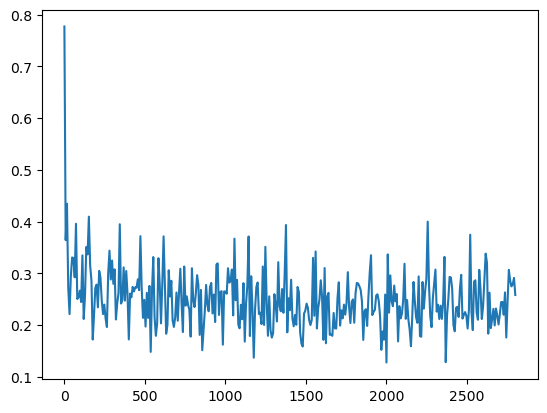

In [597]:
!openai wandb sync -i ft-Ms483CO61JALOuyoJ1MF5cWI
!openai api fine_tunes.results -i ft-Ms483CO61JALOuyoJ1MF5cWI > result.csv

pd.read_csv('result.csv')['validation_loss'].dropna().plot()

In [ ]:
# TODO accuracy of ada and curie with no fine tuning

In [601]:
custom_socratic_testing_rows[0]

{'prompt': "Query: Janet’s ducks lay 16 eggs per day. She eats three for breakfast every morning and bakes muffins for her friends every day with four. She sells the remainder at the farmers' market daily for $2 per fresh duck egg. How much in dollars does she make every day at the farmers' market?\n\nReasoning:",
 'completion': " How many eggs does Janet sell? ** Janet sells 16 - 3 - 4 = <<16-3-4=9>>9 duck eggs a day.\nHow much does Janet make at the farmers' market? ** She makes 9 * 2 = $<<9*2=18>>18 every day at the farmer’s market.\n\nMy final answer is: 18"}

In [633]:
results = evaluate_performance(
    'curie:ft-personal-2023-03-26-15-09-27', socratic_testing_rows, '####', temperature=0
)

for key, value in results.items():
    print(f'{key}: {value:.2f}')

100%|██████████████████████████████████████████████████████████████████████| 1319/1319 [54:16<00:00,  2.47s/it]

accuracy: 0.16
mae: 35835.00
rmse: 741417.84


# Incremental Training, going for 3 more epochs on curie

In [674]:
!openai api fine_tunes.create --training_file "file-1I9DKcUGr0hrYjRQzoDowjiM" --validation_file "file-UzwI4ClJmSJk3ssyDkUlIt5S" --model "curie:ft-personal-2023-03-26-15-09-27" --n_epochs 3


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Created fine-tune: ft-otejFZOdkdaMD4fWQqqgZXjz
Streaming events until fine-tuning is complete...

(Ctrl-C will interrupt the stream, but not cancel the fine-tune)
[2023-03-29 08:36:57] Created fine-tune: ft-otejFZOdkdaMD4fWQqqgZXjz

Stream interrupted (client disconnected).
To resume the stream, run:

  openai api fine_tunes.follow -i ft-otejFZOdkdaMD4fWQqqgZXjz



In [675]:
!openai api fine_tunes.follow -i ft-otejFZOdkdaMD4fWQqqgZXjz


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
[2023-03-29 08:36:57] Created fine-tune: ft-otejFZOdkdaMD4fWQqqgZXjz

Stream interrupted (client disconnected).
To resume the stream, run:

  openai api fine_tunes.follow -i ft-otejFZOdkdaMD4fWQqqgZXjz



In [ ]:
!openai wandb sync -i ft-otejFZOdkdaMD4fWQqqgZXjz
!openai api fine_tunes.results -i ft-otejFZOdkdaMD4fWQqqgZXjz > result.csv

pd.read_csv('result.csv')['validation_loss'].dropna().plot()

In [ ]:
# maybe save few shot for chapter 5 to see if it improves things? First try to evaluate accuracy

In [370]:
from sentence_transformers import SentenceTransformer, util

# Assuming you have a list of 1000 text documents
documents = [socratic_training_row['prompt'] for socratic_training_row in socratic_training_rows]

# Load a pre-trained biencoder for embedding text
model_name = "sentence-transformers/paraphrase-MiniLM-L6-v2"
model = SentenceTransformer(model_name)

# Create embeddings for your documents
embeddings = model.encode(documents)


Downloading:   0%|          | 0.00/690 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.69k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/629 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/314 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

In [374]:
socratic_testing_rows[0]['prompt']

"Janet’s ducks lay 16 eggs per day. She eats three for breakfast every morning and bakes muffins for her friends every day with four. She sells the remainder at the farmers' market daily for $2 per fresh duck egg. How much in dollars does she make every day at the farmers' market?"

In [375]:
# Example query
query = socratic_testing_rows[0]['prompt']

# Embed the query
query_embedding = model.encode([query])[0]

# Perform a semantic search to retrieve the top 3 results
results = util.semantic_search(query_embedding, embeddings, top_k=3)

# Print the results
for result in results[0]:
    idx, score = result['corpus_id'], result['score']
    print(f"Document: {documents[idx]} - Score: {score}")


Document: Kelly has 8 chickens that lay 3 eggs each per day. If Kelly sells these eggs for $5 a dozen. How much money will she make in 4 weeks if she sells all her eggs? - Score: 0.7399358749389648
Document: Jane runs a small farm.  She has 10 chickens that lay 6 eggs each per week. She can sell the eggs for $2/dozen.  How much money will she make in 2 weeks if she sells all her eggs? - Score: 0.7393282651901245
Document: A farmer is selling ducks and chickens at the market. He sells ducks for $10 and chickens for $8. He sells 5 chickens and some ducks. He then spends half his earnings on a new wheelbarrow. After buying it, someone sees it and agrees to pay the farmer double what the farmer paid and the farmer earns another $60. How many ducks did the farmer sell? - Score: 0.7047860026359558
